Finding Dominant Color Names from Color Space Coordinates and Images
=========================================

![](jupysmug.png)

### Let's install some software.

This notebook will explore various techniques for analyzing the contents of digital images
and computing:

1.  Color names from RGB color space coordinates.

2.  Finding a color "nearest" a preset palette of colors.

3.  Computing an image's dominant color and returning a "nearest" color name.

The methods tested here were collected from many 
sources, ["Lesser artists borrow, great artists steal."](https://www.brainyquote.com/quotes/igor_stravinsky_137813)
One of these days I will have to blog about the difference between ***programming***, *thinking for yourself*,
and ***gargling***, *looking up code snippets on the web.* 

Testing disparate code snippets always turns into a configuration exercise.
The following install commands gather required packages that I didn't find in the Anaconda distribution.

In [1]:
# decomment to run
#!cd \anaconda3
#!python -m pip install webcolors

In [2]:
#!cd \anaconda3
#!python -m pip install Pillow

### Notebook Imports

In [3]:
import webcolors
import numpy as np
import struct
from PIL import Image
from matplotlib import pyplot as plt
import scipy
import scipy.misc
import scipy.cluster
from collections import namedtuple
from math import sqrt
import random
from sklearn.cluster import KMeans
import math
import glob
import os
import csv

### Using `webcolors` to Reverse Color Code.

After installing `webcolors` test it with this code snippet from [Stack Overflow](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

In [4]:
# modified to return distance from actual color
def closest_color(requested_color):
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return (min_colors[min(min_colors.keys())], sqrt(min(min_colors.keys()))) 

def get_color_name(requested_color):
    try:
        rgb_distance = 0
        closest_name = actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name , rgb_distance = closest_color(requested_color)
        actual_name = None
    return (actual_name, closest_name, rgb_distance)

requested_color = (119, 172, 152)
actual_name, closest_name , rgb_distance = get_color_name(requested_color)

print("Actual color name:", actual_name, ", closest color name:", closest_name, " rgb distance:", rgb_distance)

Actual color name: None , closest color name: cadetblue  rgb distance: 28.91366458960192


In [5]:
rgb0 = (0,0,0)
rgb1 = (255,255,255)
rgb2 = (255,0,0)
rgb3 = (0,255,0)
rgb4 = (0,0,255)

print(get_color_name(rgb0))
print(get_color_name(rgb1))
print(get_color_name(rgb2))
print(get_color_name(rgb3))
print(get_color_name(rgb4))

('black', 'black', 0)
('white', 'white', 0)
('red', 'red', 0)
('lime', 'lime', 0)
('blue', 'blue', 0)


### Generate Some Random Colors

In [6]:
print(random.randint(0, 255))

110


In [7]:
for a,b in 15 * [(0,255)]:
    rgb = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    print(get_color_name(rgb)[1:])

('darkslateblue', 41.773197148410844)
('darkseagreen', 28.600699292150182)
('darkslategrey', 51.94227565288221)
('skyblue', 29.427877939124322)
('lightsteelblue', 40.91454509095757)
('mediumvioletred', 52.81098370604357)
('lightskyblue', 14.560219778561036)
('brown', 26.92582403567252)
('orangered', 38.79432948254165)
('indianred', 47.853944456021594)
('sandybrown', 33.04542328371661)
('orchid', 39.59797974644666)
('darksalmon', 30.805843601498726)
('forestgreen', 48.92851929090027)
('greenyellow', 19.82422760159901)


### Loading Test Images

The following images, selected from the 
directories [generated by](https://github.com/bakerjd99/smugpyter/blob/master/notebooks/smugpyter.py) `SmugPyter`,
will be used to test various dominant color calculations.

In [8]:
# mqny digital images are huge - this utility shrinks images 
def resize_image(image, factor=0.4):
    """Resize PIL image maintaining aspect ratio."""
    imcopy = image.copy()
    width, height = imcopy.size
    width = int(factor * width)
    height = int(factor * height) 
    return imcopy.resize((width, height))

In [9]:
# test images SmugMirror directories
path_head = 'C:/SmugMirror/Mirror/'
image1 = Image.open(path_head + 'Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
image2 = Image.open(path_head + 'Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')
image3 = Image.open(path_head + 'People/GreatandGreaterForebearers/LX8HmDV-2z-william-evert-baker-portrait-1950.jpg')
image4 = Image.open(path_head + 'Themes/Manipulations/Panoramas/b36sc3H-1-norris-porcelain-basin-yellowstone-panorma.jpg')

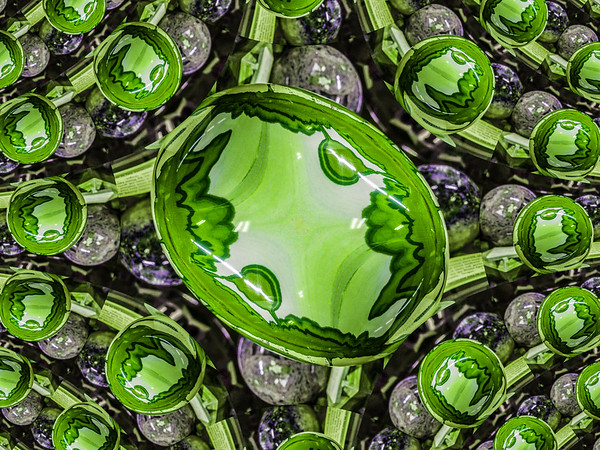

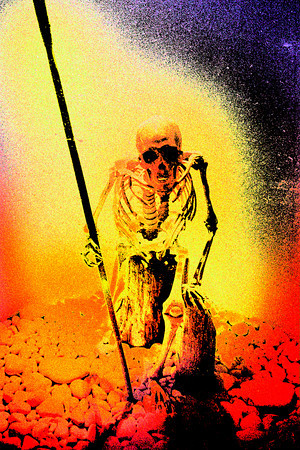

In [10]:
display(image1)
display(image2)

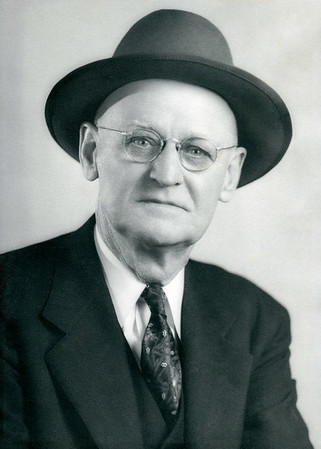

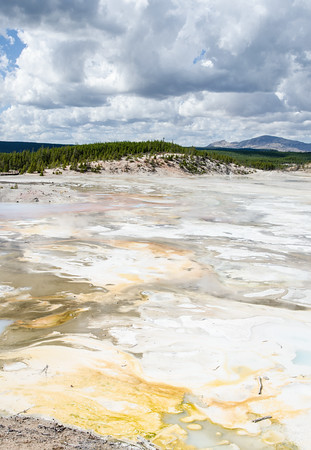

In [11]:
display(image3)
display(image4)

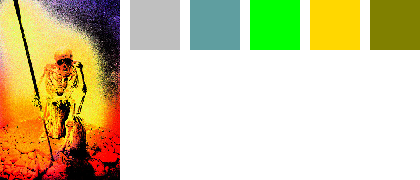

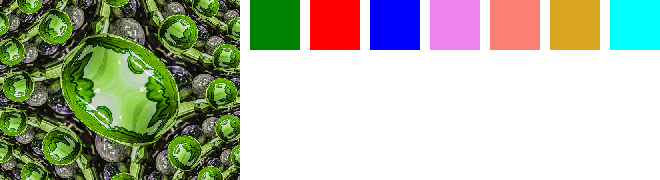

In [12]:
def show_image_name_colors(image, color_names, *, factor=0.4, patch_size=(50,50), spacing=10):
    """Display resized image with adjacent named color patches."""
    imnew = resize_image(image, factor)
    # NIMP check that image is larger than patch size
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(color_names)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    for i, name in enumerate(color_names):
        patch = Image.new("RGB", patch_size, name)
        background.paste(patch, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
    display(background)

show_image_name_colors(image2, ["silver","cadetblue","lime","gold","olive"])
show_image_name_colors(image1, ["green","red","blue","violet","salmon","goldenrod","cyan"])    

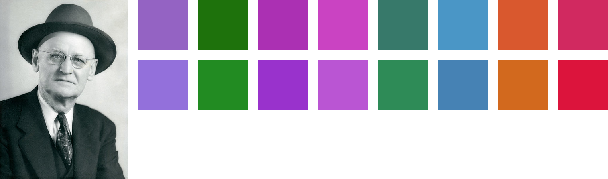

[('mediumpurple', 27.31), ('forestgreen', 33.54), ('darkorchid', 30.87), ('mediumorchid', 29.48), ('seagreen', 27.68), ('steelblue', 27.2), ('chocolate', 24.37), ('crimson', 43.1)]
mean:         30.44
variance:     29.48
standard dev: 5.43


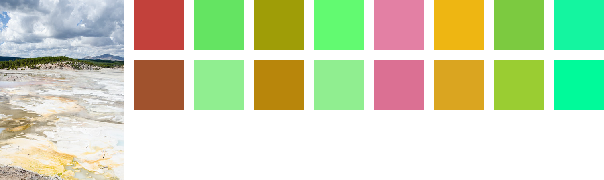

[('sienna', 40.51), ('lightgreen', 64.44), ('darkgoldenrod', 34.21), ('lightgreen', 56.75), ('palevioletred', 24.68), ('goldenrod', 29.75), ('yellowgreen', 33.24), ('mediumspringgreen', 21.47)]
mean:         38.13
variance:     201.57
standard dev: 14.20


In [13]:
def show_image_colors(image, colors, *, factor=0.4, patch_size=(50,50), spacing=10):
    """
    Display resized image with adjacent color patches.
    The top patch row shows raw colors and the second
    shows nearest named colors.
    """
    imnew = resize_image(image, factor)
    # NIMP check that image is 2 * larger than patch size.
    height = imnew.size[1]
    width = imnew.size[0] + (spacing + patch_size[0]) * len(colors)
    background = Image.new('RGBA', (width,height), (255, 255, 255, 255))
    background.paste(imnew, (0,0))
    rgb_distance = []
    color_name = []
    for i, color in enumerate(colors):
        r, g, b = color
        patch1 = Image.new("RGB", patch_size, (int(r),int(g),int(b)))
        background.paste(patch1, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), 0))
        name , rgb_metric = get_color_name((r,g,b))[1:]
        rgb_distance.append(rgb_metric)
        color_name.append(name)
        patch2 = Image.new("RGB", patch_size, name)
        background.paste(patch2, (imnew.size[0] + spacing +  i * (spacing + patch_size[0]), spacing + patch_size[1]))
    display(background)
    print([(n,float("{0:.2f}".format(d))) for (n,d) in zip(color_name,rgb_distance)])
    print("mean:         %s" % "{0:.2f}".format(np.mean(rgb_distance)))
    print("variance:     %s" % "{0:.2f}".format(np.var(rgb_distance)))
    print("standard dev: %s" % "{0:.2f}".format(np.std(rgb_distance)))

rcolors0 = []
rcolors1 = []
for a,b in 8 * [(0,255)]:
    rgb0 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rgb1 = (random.randint(a,b), random.randint(a,b), random.randint(a,b))
    rcolors0.append(rgb0)
    rcolors1.append(rgb1)
    
show_image_colors(image3, rcolors0)
show_image_colors(image4, rcolors1)   

### First Dominant Color Calculation

After making some minor code edits it's possible to 
run this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image).

In [14]:
def array_from_image(image, *, factor=0.4):
    image = resize_image(image, factor)
    ar = np.asarray(image)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    return ar

def calc1_colors(ar, *, num_clusters=8, factor=0.4):
    colors, dist = scipy.cluster.vq.kmeans(ar, num_clusters)
    return colors

def calc1_peak(ar, colors):
    vecs, dist = scipy.cluster.vq.vq(ar, colors)        # assign codes
    counts, bins = scipy.histogram(vecs, len(colors))   # count occurrences
    index_max = scipy.argmax(counts)                    # find most frequent
    peak = colors[index_max]
    return peak

def calc1_colors_peak(image, *, num_clusters=8, factor=0.4):
    ar = array_from_image(image, factor=factor)
    colors = calc1_colors(ar, num_clusters=num_clusters)
    peak = calc1_peak(ar, colors)
    return (colors, peak)
    
NUM_CLUSTERS = 8

calc1_colors1, calc1_peak1 = calc1_colors_peak(image1, num_clusters=NUM_CLUSTERS) 
calc1_colors2, calc1_peak2 = calc1_colors_peak(image2, num_clusters=NUM_CLUSTERS) 
calc1_colors3, calc1_peak3 = calc1_colors_peak(image3, num_clusters=NUM_CLUSTERS) 
calc1_colors4, calc1_peak4 = calc1_colors_peak(image4, num_clusters=NUM_CLUSTERS) 

print('peak1', calc1_peak1)
print('peak2', calc1_peak2)
print('peak3', calc1_peak3)
print('peak4', calc1_peak4)

peak1 [18.27835794 24.02223623 10.64791142]
peak2 [240.69752104 223.39367751 132.49010689]
peak3 [224.96441911 226.98781207 223.35423629]
peak4 [240.31197218 238.55191257 233.58817685]


### Display Cluster and Named Colors for the First Calculation

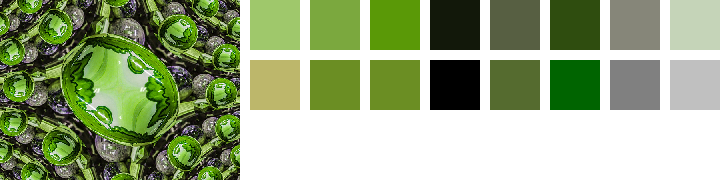

[('darkkhaki', 34.16), ('olivedrab', 41.29), ('olivedrab', 34.13), ('black', 32.01), ('darkolivegreen', 23.1), ('darkgreen', 55.14), ('grey', 11.37), ('silver', 22.27)]
mean:         31.68
variance:     153.68
standard dev: 12.40


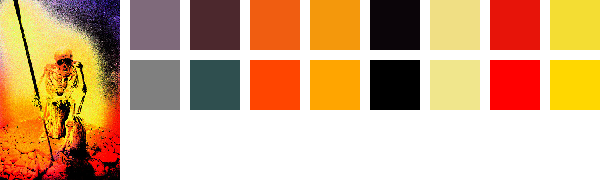

[('grey', 21.7), ('darkslategrey', 59.01), ('orangered', 33.17), ('orange', 20.55), ('black', 15.76), ('khaki', 10.03), ('red', 32.43), ('gold', 52.62)]
mean:         30.66
variance:     265.72
standard dev: 16.30


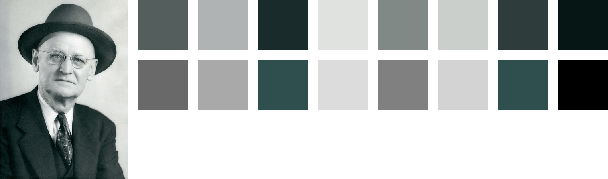

[('dimgrey', 25.93), ('darkgrey', 16.51), ('darkslategrey', 55.72), ('gainsboro', 9.2), ('grey', 12.0), ('lightgrey', 12.12), ('darkslategrey', 26.18), ('black', 32.56)]
mean:         23.78
variance:     205.94
standard dev: 14.35


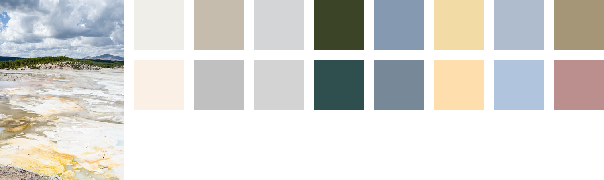

[('linen', 10.43), ('silver', 20.11), ('lightgrey', 4.44), ('darkslategrey', 42.66), ('lightslategrey', 33.41), ('navajowhite', 13.79), ('lightsteelblue', 17.92), ('rosybrown', 33.31)]
mean:         22.01
variance:     151.83
standard dev: 12.32


In [15]:
show_image_colors(image1, calc1_colors1)   
show_image_colors(image2, calc1_colors2)
show_image_colors(image3, calc1_colors3)
show_image_colors(image4, calc1_colors4)

### Second Dominant Color Calculation

This algorithm, due to [Charlies Leifer](https://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/), also computes dominant colors.

In [16]:
Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def calc2_colors(image, *, num_clusters=8, factor=0.4):
    img = resize_image(image, factor)
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, num_clusters, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs)

def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

In [17]:
dmap1 = calc2_colors(image1, num_clusters=8)
dmap2 = calc2_colors(image2, num_clusters=8)
dmap3 = calc2_colors(image3, num_clusters=8)
dmap4 = calc2_colors(image4, num_clusters=8)
colors1 = [webcolors.hex_to_rgb(i) for i in list(dmap1)]
colors2 = [webcolors.hex_to_rgb(i) for i in list(dmap2)]
colors3 = [webcolors.hex_to_rgb(i) for i in list(dmap3)]
colors4 = [webcolors.hex_to_rgb(i) for i in list(dmap4)]

### Display Cluster and Named Colors for the Second Calculation

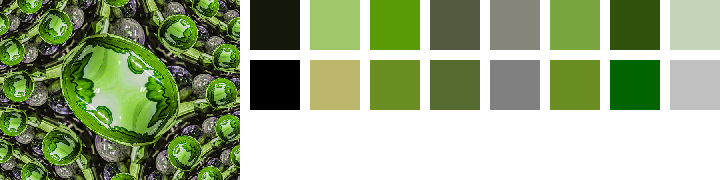

[('black', 32.53), ('darkkhaki', 34.5), ('olivedrab', 34.77), ('darkolivegreen', 23.37), ('grey', 9.95), ('olivedrab', 39.81), ('darkgreen', 52.89), ('silver', 22.11)]
mean:         31.24
variance:     145.67
standard dev: 12.07


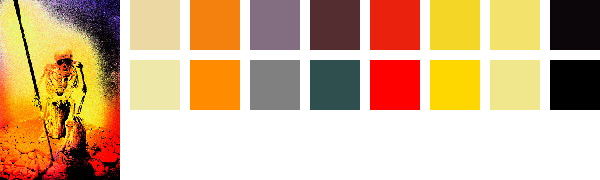

[('palegoldenrod', 18.0), ('darkorange', 20.83), ('grey', 18.11), ('darkslategrey', 58.96), ('red', 40.91), ('gold', 39.56), ('khaki', 33.38), ('black', 16.73)]
mean:         30.81
variance:     200.08
standard dev: 14.14


In [18]:
show_image_colors(image1, colors1)
show_image_colors(image2, colors2)

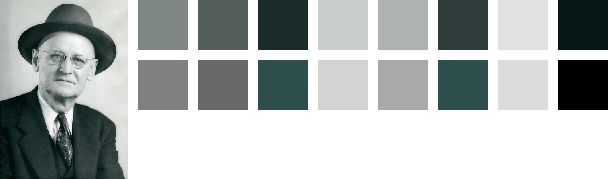

[('grey', 9.27), ('dimgrey', 26.57), ('darkslategrey', 55.09), ('lightgrey', 14.35), ('darkgrey', 13.67), ('darkslategrey', 26.17), ('gainsboro', 7.81), ('black', 32.59)]
mean:         23.19
variance:     215.64
standard dev: 14.68


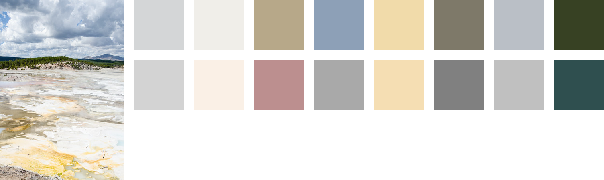

[('lightgrey', 5.1), ('linen', 10.63), ('rosybrown', 26.19), ('darkgrey', 32.57), ('wheat', 10.3), ('grey', 24.12), ('silver', 8.54), ('darkslategrey', 46.86)]
mean:         20.54
variance:     183.49
standard dev: 13.55


In [19]:
show_image_colors(image3, colors3)
show_image_colors(image4, colors4)

## Third Dominant Color Calculation

This algorithm, due to [Srijan Anand](https://github.com/srijannnd/Dominant-Color-Extraction-Dominance-and-Recoloring), is another variation on *kmeans*. The original notebook code required
some changes as `cv2` is not currently available for Python 3.6 Win64 Anaconda systems. It can be replaced
with `PIL`.

In [20]:
km = KMeans(n_clusters=8)
print(km)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [21]:
def calc3_colors(image, num_clusters=8):
    km = KMeans(n_clusters=num_clusters)
    image = resize_image(image, factor=0.4)
    ar = np.asarray(image)
    shape = ar.shape
    pixels = ar.reshape((-1, 3))
    km.fit(pixels)
    colors = np.asarray(km.cluster_centers_, dtype='uint8')
    # improved rounding - has little effect
    #colors = np.asarray(np.around(km.cluster_centers_,0), dtype='uint8')
    return (colors, pixels, km)

def calc3_percentage(pixels, km):
    percentage = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype='float32')
    percentage = percentage/pixels.shape[0]
    return percentage

In [22]:
def calc3_dominance_patch(colors, pixels, km):
    percentage = calc3_percentage(pixels, km)
    dom = [[percentage[ix], colors[ix]] for ix in range(km.n_clusters)]
    dominance = sorted(dom, key=lambda x:x[0], reverse=True)
    plt.figure(0)
    plt.axis("off")
    patch = np.zeros((50, 500, 3), dtype=np.uint8)
    start = 0
    names = []
    for cx in range(km.n_clusters):
        da = dominance[cx][0] * patch.shape[1]
        width = int(da)
        end = start + width
        cb = dominance[cx][1]
        # nearest named color
        nc = get_color_name(cb)[1]  
        names.append(nc)
        r, g, b = webcolors.name_to_rgb(nc)
        #patch[:, start:end, :] = 255 - np.asarray([r,g,b], dtype=np.uint8)
        patch[:, start:end, :] = np.asarray([r,g,b], dtype=np.uint8)
        start = end
    plt.imshow(patch)
    plt.show()
    print(names)

colors1 , pixels1 , km1 = calc3_colors(image1)
colors2 , pixels2 , km2 = calc3_colors(image2)
colors3 , pixels3 , km3 = calc3_colors(image3)
colors4 , pixels4 , km4 = calc3_colors(image4)

### Display Cluster and Named Colors for the Third Calculation

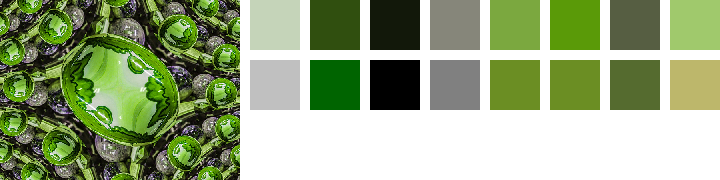

[('silver', 21.77), ('darkgreen', 54.5), ('black', 31.62), ('grey', 10.39), ('olivedrab', 41.42), ('olivedrab', 34.09), ('darkolivegreen', 23.04), ('darkkhaki', 34.15)]
mean:         31.37
variance:     156.58
standard dev: 12.51


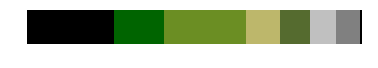

['black', 'darkgreen', 'olivedrab', 'olivedrab', 'darkkhaki', 'darkolivegreen', 'silver', 'grey']


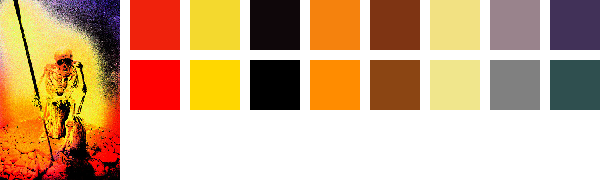

[('red', 39.05), ('gold', 47.34), ('black', 19.34), ('darkorange', 19.21), ('saddlebrown', 21.4), ('khaki', 11.36), ('grey', 27.89), ('darkslategrey', 36.12)]
mean:         27.71
variance:     129.29
standard dev: 11.37


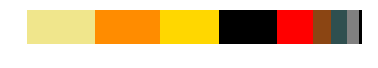

['khaki', 'darkorange', 'gold', 'black', 'red', 'saddlebrown', 'darkslategrey', 'grey']


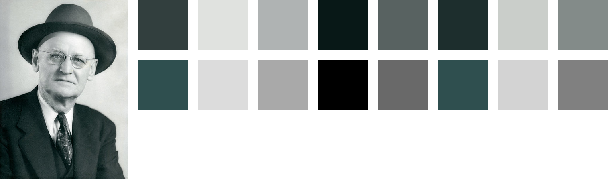

[('darkslategrey', 23.54), ('gainsboro', 7.81), ('darkgrey', 15.36), ('black', 34.19), ('dimgrey', 20.05), ('darkslategrey', 50.69), ('lightgrey', 13.67), ('grey', 14.53)]
mean:         22.48
variance:     168.30
standard dev: 12.97


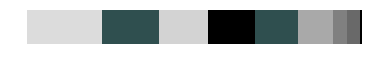

['gainsboro', 'darkslategrey', 'lightgrey', 'black', 'darkslategrey', 'darkgrey', 'grey', 'dimgrey']


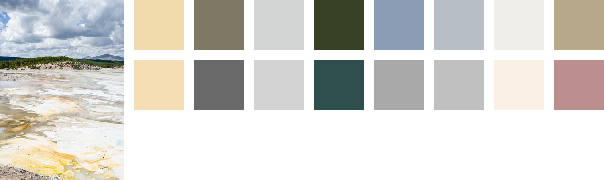

[('wheat', 10.3), ('dimgrey', 26.93), ('lightgrey', 2.83), ('darkslategrey', 46.86), ('darkgrey', 35.34), ('silver', 10.49), ('linen', 10.63), ('rosybrown', 26.19)]
mean:         21.20
variance:     199.88
standard dev: 14.14


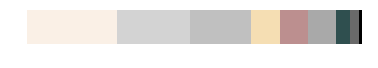

['linen', 'lightgrey', 'silver', 'wheat', 'rosybrown', 'darkgrey', 'darkslategrey', 'dimgrey']


In [23]:
show_image_colors(image1, colors1)
calc3_dominance_patch(colors1, pixels1, km1)
show_image_colors(image2, colors2)
calc3_dominance_patch(colors2, pixels2, km2)
show_image_colors(image3, colors3)
calc3_dominance_patch(colors3, pixels3, km3)
show_image_colors(image4, colors4)
calc3_dominance_patch(colors4, pixels4, km4)

### First Named Color Selection Tests

All these *kmeans* algorithms produce similar results. The first and third calculations are faster
than the second which is to be expected from library routines. When the raw colors are mapped
to named colors the shifts can lead to poor choices. To refine the choice this heuristic is employed.

1. Look at the list of named colors. If a named color appears more than once pick the most
   frequently occuring name. For the third calculation "olivedrab" appears twice. I think
   this is a better choice than the dominant most frequent raw color that is mapped to "black."
   
2. If there are no repeated named colors toss out greatest color distance, compute the remaining
   mean and standard deviation. Sort the colors by frequency then pick the first color
   with a distance that is less than or equal one standard deviation from the mean.
   
The following functions implement this method.

In [24]:
def dualsort(a, b, *, reverse=False):
        """
        Sort lists (a) and (b) using (a) to grade (b).
        """
        temp = sorted(zip(a, b), key=lambda x: x[0], reverse=reverse)
        return list(map(list, zip(*temp)))
    
def most_common(lst):
        """ Pick most common item in a list - ok for small lists."""
        return max(set(lst), key=lst.count)

def pixel_selections(image, *, sample=False, factor=0.4, portion=10, pixel_func=None):
        """
        Returns a tuple of pixel selections from an image. The first item
        contains all the pixels of the resized image and the second
        contains a subset chosen by (pixel_func) when (sample) is (True)
        and (pixel_func) exists and returns a valid result.
        """
        imcopy = resize_image(image, factor=factor)
        ar = np.asarray(imcopy)
        all_pixels = ar.reshape((-1,3))
        some_pixels = None if not sample else None if pixel_func is None else pixel_func(ar, portion=portion)
        some_pixels = None if some_pixels is None else some_pixels[1] if some_pixels[0] else None
        return (all_pixels, some_pixels)
    
def name_freq_dist_from_pixels(pixels, num_clusters=8):
        """
        Return a tuple of color names, frequencies and distances from raw RGB colors.
        """
        km = KMeans(n_clusters=num_clusters)
        km.fit(pixels)
        colors = np.asarray(km.cluster_centers_, dtype=np.uint8)
        frequencies = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype=np.int32)
        names = []
        distances = []
        for color in colors:
            _, name, rgb_distance = get_color_name(color)
            names.append(name)
            distances.append(rgb_distance)
        return (names, frequencies, distances)

def order_colors(names_freqs_dists):
    """Order by decreasing frequency"""
    names, frequencies, distances = names_freqs_dists
    _, names = dualsort(frequencies, names, reverse=True)
    frequencies, distances = dualsort(frequencies, distances, reverse=True)
    return (names, frequencies, distances)
    
def dominant_color_key1(image, *, sample=False, num_clusters=8, factor=0.4, portion=10, pixel_func=None):
        """
        Return a single dominant color key.
        """     
        pixels, some_pixels = pixel_selections(image, sample=sample, 
                                     factor=factor, portion=portion, 
                                     pixel_func=pixel_func) 
        
        # use some region of the image selected by (pixel_func) 
        pixels = pixels if not sample else pixels if some_pixels is None else some_pixels
        
        names, frequencies, distances = order_colors(name_freq_dist_from_pixels(pixels, 
                                                                                num_clusters=num_clusters))
        if len(names) > len(list(set(names))):
            # most frequent repeated named color
            key = most_common(names)
        else:
            # distances less greatest outlier
            dist_sample = sorted(distances, reverse=True)[1:]
            threshold = np.mean(dist_sample) + np.std(dist_sample)
            
            # default color choice
            key = names[0]
            
            # return first color from sorted names that is no more
            # than one standard deviation from the sample mean. If
            # no such choice is made retain the default selection.
            for name, distance in zip(names, distances): 
                if distance <= threshold:
                    key = name
                    break
                
        return key.lower().strip()
    
print(dominant_color_key1(image1))
print(dominant_color_key1(image2))
print(dominant_color_key1(image3))
print(dominant_color_key1(image4))

olivedrab
khaki
darkslategrey
linen


### Frequencies of Color Keys

I applied this method to all the sample images in my `c:/SmugMirror` directories and analyzed
the color assignments. The following table summarizes the results.

        +-----+-----------------------+---------+-----------+-----------+-------+
        |count|color key              |frequency|percent    |cummulative|reverse|
        +-----+-----------------------+---------+-----------+-----------+-------+
        | 1   |`0_darkslategrey       |702      |  16.521534|16.521534  |4249   |
        | 2   |`0_black               |549      |  12.920687|29.442222  |3547   |
        | 3   |`0_dimgrey             |286      |  6.7309955|36.173217  |2998   |
        | 4   |`0_darkgrey            |263      |  6.1896917|42.362909  |2712   |
        | 5   |`0_grey                |250      |  5.8837373|48.246646  |2449   |
        | 6   |`0_darkolivegreen      |244      |  5.7425277|53.989174  |2199   |
        | 7   |`0_silver              |223      |  5.2482937|59.237468  |1955   |
        | 8   |`0_gainsboro           |142      |  3.3419628| 62.57943  |1732   |
        | 9   |`0_lightsteelblue      |139      |   3.271358|65.850788  |1590   |
        |10   |`0_steelblue           |128      |  3.0124735|68.863262  |1451   |
        |11   |`0_lightgrey           |113      |  2.6594493|71.522711  |1323   |
        |12   |`0_rosybrown           |108      |  2.5417745|74.064486  |1210   |
        |13   |`0_lavender            | 94      |  2.2122852|76.276771  |1102   |
        |14   |`0_tan                 | 83      |  1.9534008|78.230172  |1008   |
        |15   |`0_whitesmoke          | 49      |  1.1532125|79.383384  | 925   |
        |16   |`0_lightslategrey      | 48      |  1.1296776|80.513062  | 876   |
        |17   |`0_cornflowerblue      | 48      |  1.1296776|81.642739  | 828   |
        |18   |`0_sienna              | 47      |  1.1061426|82.748882  | 780   |
        |19   |`0_midnightblue        | 39      | 0.91786303|83.666745  | 733   |
        |20   |`0_peru                | 39      | 0.91786303|84.584608  | 694   |
        |21   |`0_lightblue           | 38      | 0.89432808|85.478936  | 655   |
        |22   |`0_linen               | 37      | 0.87079313|86.349729  | 617   |
        |23   |`0_olivedrab           | 32      | 0.75311838|87.102848  | 580   |
        |24   |`0_white               | 30      | 0.70604848|87.808896  | 548   |
        |25   |`0_burlywood           | 30      | 0.70604848|88.514945  | 518   |
        |26   |`0_skyblue             | 30      | 0.70604848|89.220993  | 488   |
        |27   |`0_darkkhaki           | 28      | 0.65897858|89.879972  | 458   |
        |28   |`0_saddlebrown         | 27      | 0.63544363|90.515415  | 430   |
        |29   |`0_wheat               | 27      | 0.63544363|91.150859  | 403   |
        |30   |`0_snow                | 24      | 0.56483879|91.715698  | 376   |
        |31   |`0_darkslateblue       | 21      | 0.49423394|92.209932  | 352   |
        |32   |`0_slategrey           | 20      | 0.47069899|92.680631  | 331   |
        |33   |`0_antiquewhite        | 17      | 0.40009414|93.080725  | 311   |
        |34   |`0_cadetblue           | 16      | 0.37655919|93.457284  | 294   |
        |35   |`0_powderblue          | 15      | 0.35302424|93.810308  | 278   |
        |36   |`0_indianred           | 14      | 0.32948929|94.139798  | 263   |
        |37   |`0_firebrick           | 12      | 0.28241939|94.422217  | 249   |
        |38   |`0_darkseagreen        | 11      | 0.25888444|94.681101  | 237   |
        |39   |`0_maroon              | 10      | 0.23534949|94.916451  | 226   |
        |40   |`0_lightskyblue        | 10      | 0.23534949|  95.1518  | 216   |
        |41   |`0_ghostwhite          |  9      | 0.21181454|95.363615  | 206   |
        |42   |`0_bisque              |  9      | 0.21181454| 95.57543  | 197   |
        |43   |`0_royalblue           |  8      |  0.1882796|95.763709  | 188   |
        |44   |`0_goldenrod           |  8      |  0.1882796|95.951989  | 180   |
        |45   |`0_chocolate           |  8      |  0.1882796|96.140268  | 172   |
        |46   |`0_sandybrown          |  8      |  0.1882796|96.328548  | 164   |
        |47   |`0_oldlace             |  7      | 0.16474465|96.493293  | 156   |
        |48   |`0_teal                |  7      | 0.16474465|96.658037  | 149   |
        |49   |`0_deepskyblue         |  7      | 0.16474465|96.822782  | 142   |
        |50   |`0_beige               |  6      |  0.1412097|96.963992  | 135   |
        |51   |`0_palegoldenrod       |  6      |  0.1412097|97.105201  | 129   |
        |52   |`0_brown               |  6      |  0.1412097|97.246411  | 123   |
        |53   |`0_thistle             |  6      |  0.1412097|97.387621  | 117   |
        |54   |`0_orangered           |  6      |  0.1412097| 97.52883  | 111   |
        |55   |`0_crimson             |  5      | 0.11767475|97.646505  | 105   |
        |56   |`0_olive               |  5      | 0.11767475| 97.76418  | 100   |
        |57   |`0_darksalmon          |  5      | 0.11767475|97.881855  |  95   |
        |58   |`0_seagreen            |  5      | 0.11767475|97.999529  |  90   |
        |59   |`0_aliceblue           |  5      | 0.11767475|98.117204  |  85   |
        |60   |`0_paleturquoise       |  4      |0.094139798|98.211344  |  80   |
        |61   |`0_khaki               |  4      |0.094139798|98.305484  |  76   |
        |62   |`0_lightyellow         |  3      |0.070604848|98.376088  |  72   |
        |63   |`0_lightgoldenrodyellow|  3      |0.070604848|98.446693  |  69   |
        |64   |`0_darkred             |  3      |0.070604848|98.517298  |  66   |
        |65   |`0_floralwhite         |  3      |0.070604848|98.587903  |  63   |
        |66   |`0_navajowhite         |  3      |0.070604848|98.658508  |  60   |
        |67   |`0_darkgoldenrod       |  3      |0.070604848|98.729113  |  57   |
        |68   |`0_tomato              |  3      |0.070604848|98.799718  |  54   |
        |69   |`0_deeppink            |  3      |0.070604848|98.870322  |  51   |
        |70   |`0_darkcyan            |  3      |0.070604848|98.940927  |  48   |
        |71   |`0_palevioletred       |  3      |0.070604848|99.011532  |  45   |
        |72   |`0_mintcream           |  3      |0.070604848|99.082137  |  42   |
        |73   |`0_mediumblue          |  3      |0.070604848|99.152742  |  39   |
        |74   |`0_pink                |  2      |0.047069899|99.199812  |  36   |
        |75   |`0_gold                |  2      |0.047069899|99.246882  |  34   |
        |76   |`0_darkblue            |  2      |0.047069899|99.293952  |  32   |
        |77   |`0_orchid              |  2      |0.047069899|99.341021  |  30   |
        |78   |`0_lightpink           |  2      |0.047069899|99.388091  |  28   |
        |79   |`0_seashell            |  2      |0.047069899|99.435161  |  26   |
        |80   |`0_mediumseagreen      |  2      |0.047069899|99.482231  |  24   |
        |81   |`0_dodgerblue          |  2      |0.047069899|99.529301  |  22   |
        |82   |`0_lightcyan           |  2      |0.047069899|99.576371  |  20   |
        |83   |`0_darkturquoise       |  2      |0.047069899|99.623441  |  18   |
        |84   |`0_red                 |  1      |0.023534949|99.646976  |  16   |
        |85   |`0_yellow              |  1      |0.023534949|99.670511  |  15   |
        |86   |`0_cornsilk            |  1      |0.023534949|99.694046  |  14   |
        |87   |`0_mistyrose           |  1      |0.023534949|99.717581  |  13   |
        |88   |`0_mediumaquamarine    |  1      |0.023534949|99.741116  |  12   |
        |89   |`0_plum                |  1      |0.023534949|99.764651  |  11   |
        |90   |`0_darkmagenta         |  1      |0.023534949|99.788185  |  10   |
        |91   |`0_hotpink             |  1      |0.023534949| 99.81172  |   9   |
        |92   |`0_peachpuff           |  1      |0.023534949|99.835255  |   8   |
        |93   |`0_blanchedalmond      |  1      |0.023534949| 99.85879  |   7   |
        |94   |`0_lavenderblush       |  1      |0.023534949|99.882325  |   6   |
        |95   |`0_blue                |  1      |0.023534949| 99.90586  |   5   |
        |96   |`0_mediumpurple        |  1      |0.023534949|99.929395  |   4   |
        |97   |`0_navy                |  1      |0.023534949| 99.95293  |   3   |
        |98   |`0_slateblue           |  1      |0.023534949|99.976465  |   2   |
        |99   |`0_orange              |  1      |0.023534949|      100  |   1   |
        +-----+-----------------------+---------+-----------+-----------+-------+
        
A number of things are apparent from this test.

1. Only 99 of 147 possible colors appear: about 67%.

2. The first six colors are assigned to over 50% of all images.

3. The first color is assigned more often than the last 79 colors.

4. *kmeans* dominant colors are not particularily meaningful for photographs.

### A Revised Color Selection

To reduce the frequency of the first seven selections the following revised function
accepts these colors only a certain percentage of the time.

In [25]:
over_dominant = ['darkslategrey', 'black', 'dimgrey', 'darkgrey',
                     'grey', 'darkolivegreen', 'silver']

over_threshold = 0.35

def pick_dominant_color(pixels, *, over_dominant=None, over_threshold=0.35, num_clusters=8):

    nfd = order_colors(name_freq_dist_from_pixels(pixels, num_clusters=num_clusters))
    names, frequencies, distances = nfd
    
    if len(names) > len(list(set(names))):
        # most frequent repeated named color
        key = most_common(names)
    else:
        # distances less greatest outlier
        dist_sample = sorted(distances, reverse=True)[1:]
        threshold = np.mean(dist_sample) + np.std(dist_sample)
            
        # default color choice
        key = names[0]
            
        # return first color from sorted names that is no more
        # than one standard deviation from the sample mean. If
        # no such choice is made retain the default selection.
        for name, distance in zip(names, distances): 
            if distance <= threshold:
                key = name
                break
        
        if over_dominant is not None:
            roll = random.random()   
            if (key in over_dominant) and (over_threshold < roll):
                # these keys appear to frequently
                # select another color a certain % of time
                ix = names.index(key)
                if (1 + ix) < len(names):
                    key = names[ix + 1]
                
    return key.lower().strip()

def dominant_color_key2(image, *, sample=False, num_clusters=8, factor=0.4, portion=10, pixel_func=None):
        """
        Return a single dominant color key.
        """
        pixels, some_pixels = pixel_selections(image, sample=sample, 
                                     factor=factor, portion=portion, 
                                     pixel_func=pixel_func) 
        # use some region of the image selected by (pixel_func) 
        pixels = pixels if not sample else pixels if some_pixels is None else some_pixels
        return pick_dominant_color(pixels, 
                                   over_dominant=over_dominant, 
                                   over_threshold=over_threshold,
                                   num_clusters=num_clusters)      
    
print(dominant_color_key2(image1))
print(dominant_color_key2(image2))
print(dominant_color_key2(image3))
print(dominant_color_key2(image4))

olivedrab
khaki
darkslategrey
linen


When this revised function is applied to the same set of SmugMug images we get the following table.

        +-----+-----------------------+---------+-----------+-----------+-------+
        |count|color key              |frequency|percent    |cummulative|reverse|
        +-----+-----------------------+---------+-----------+-----------+-------+
        |  1  |`0_darkslategrey       |470      |  11.061426|11.061426  |4249   |
        |  2  |`0_black               |364      |  8.5667216|19.628148  |3779   |
        |  3  |`0_dimgrey             |266      |  6.2602965|25.888444  |3415   |
        |  4  |`0_darkgrey            |230      |  5.4130384|31.301483  |3149   |
        |  5  |`0_gainsboro           |200      |  4.7069899|36.008473  |2919   |
        |  6  |`0_grey                |197      |   4.636385|40.644858  |2719   |
        |  7  |`0_darkolivegreen      |188      |  4.4245705|45.069428  |2522   |
        |  8  |`0_lightgrey           |186      |  4.3775006|49.446929  |2334   |
        |  9  |`0_rosybrown           |183      |  4.3068957|53.753824  |2148   |
        | 10  |`0_lightsteelblue      |182      |  4.2833608|58.037185  |1965   |
        | 11  |`0_steelblue           |159      |   3.742057|61.779242  |1783   |
        | 12  |`0_silver              |116      |  2.7300541|64.509296  |1624   |
        | 13  |`0_lavender            |110      |  2.5888444|67.098141  |1508   |
        | 14  |`0_tan                 |110      |  2.5888444|69.686985  |1398   |
        | 15  |`0_lightslategrey      | 79      |   1.859261|71.546246  |1288   |
        | 16  |`0_cornflowerblue      | 73      |  1.7180513|73.264297  |1209   |
        | 17  |`0_whitesmoke          | 69      |  1.6239115|74.888209  |1136   |
        | 18  |`0_saddlebrown         | 63      |  1.4827018|76.370911  |1067   |
        | 19  |`0_sienna              | 58      |  1.3650271|77.735938  |1004   |
        | 20  |`0_skyblue             | 53      |  1.2473523| 78.98329  | 946   |
        | 21  |`0_peru                | 50      |  1.1767475|80.160038  | 893   |
        | 22  |`0_midnightblue        | 49      |  1.1532125| 81.31325  | 843   |
        | 23  |`0_linen               | 44      |  1.0355378|82.348788  | 794   |
        | 24  |`0_lightblue           | 44      |  1.0355378|83.384326  | 750   |
        | 25  |`0_olivedrab           | 40      | 0.94139798|84.325724  | 706   |
        | 26  |`0_wheat               | 39      | 0.91786303|85.243587  | 666   |

              ...........................................................
              ...........................................................
              ...........................................................

        | 93  |`0_mediumorchid        |  1      |0.023534949|99.670511  |  15   |
        | 94  |`0_cornsilk            |  1      |0.023534949|99.694046  |  14   |
        | 95  |`0_yellowgreen         |  1      |0.023534949|99.717581  |  13   |
        | 96  |`0_mediumaquamarine    |  1      |0.023534949|99.741116  |  12   |
        | 97  |`0_darkmagenta         |  1      |0.023534949|99.764651  |  11   |
        | 98  |`0_hotpink             |  1      |0.023534949|99.788185  |  10   |
        | 99  |`0_blanchedalmond      |  1      |0.023534949| 99.81172  |   9   |
        |100  |`0_moccasin            |  1      |0.023534949|99.835255  |   8   |
        |101  |`0_limegreen           |  1      |0.023534949| 99.85879  |   7   |
        |102  |`0_lavenderblush       |  1      |0.023534949|99.882325  |   6   |
        |103  |`0_blue                |  1      |0.023534949| 99.90586  |   5   |
        |104  |`0_lightseagreen       |  1      |0.023534949|99.929395  |   4   |
        |105  |`0_navy                |  1      |0.023534949| 99.95293  |   3   |
        |106  |`0_slateblue           |  1      |0.023534949|99.976465  |   2   |
        |107  |`0_forestgreen         |  1      |0.023534949|      100  |   1   |
        +-----+-----------------------+---------+-----------+-----------+-------+

### Rule of Thirds Color Selection

Not all pixels are created equal. When composing photographs some regions are
of greater interest than others. The rule of thirds "suggests" that we place
subjects of primary interest near one of the five following *blue* regions.

![](rule3patches.png)

It follows that pixel samples from near these regions may produce "better" dominant
colors. The following function selects square regions around the main rule of
thirds composition points.

In [26]:
def rulethirdsq(ar, *, portion=10):
    """
    Select pixels that are centered about the five rule of thirds
    composition points. The colors in these regions are likely
    are likely to be of greater "photographic" significance
    than pixels in other parts of the image.
    """
    # image dimensions
    w = ar.shape[0]
    h = ar.shape[1]
    s = min(w,h)
    
    # all pixels as n x 3 
    px = ar.reshape((-1, 3))
    
    ok = True
    try:
        # corner multiples
        c = np.array([[1,1],[1,1],[1,2],[2,1],[2,2]])
   
        # nonzero pixel patch width and half-width 
        d1 = max(1, s // portion)
        d0 = max(1, s // (2 * portion))
        
        # pixel mask array
        b = np.zeros((w,h), dtype=np.uint8)
    
        # set rule of thirds pixel coordinates
        for n, p in enumerate(c):
        
            if n == 0:
                uc= np.array([(p[0] * w)//2, (p[1] * h)//2]) - d0 # center
            else:
                uc= np.array([(p[0] * w)//3, (p[1] * h)//3]) - d0 # corners
            
            for i in range(d1):
                for j in range(d1):
                    b[uc[0] + i, uc[1] + j] = 1
   
        # ravel mask array and select rule of thirds pixels
        b = b.reshape(-1)
        px = px[np.where(b==1)]          
    except:
        ok = False
        
    return (ok, px)

def near_chromicity(color_name):
    """
    Calculate a named color's approximate chromicity. The
    higher the value the "less neutral" the color is. The
    eye is drawn to intense colors over neutral ones.
    """
    r, g, b = webcolors.name_to_rgb(color_name)
    m = math.ceil( (int(r)+int(g)+int(b))/3 )
    return sqrt( (int(r)-m)**2 + (int(g)-m)**2 + (int(b)-m)**2 )

def dominant_color_key3(image, *, num_clusters=8, factor=0.4, portion=10, pixel_func=None):
    """
    This function combines the overall dominant color selection 
    with the dominant color from the pixels selected by (pixel_func). 
    """   
    pixels, some_pixels = pixel_selections(image, sample=True, 
                                     factor=factor, portion=portion, 
                                     pixel_func=pixel_func) 
    
    key_color = pick_dominant_color(pixels, over_dominant=over_dominant, 
                                    over_threshold=over_threshold,
                                    num_clusters=num_clusters)
    if some_pixels is None:
        rule3_color = key_color
    else:
        rule3_color = pick_dominant_color(some_pixels, over_dominant=over_dominant,
                                          over_threshold=over_threshold,
                                          num_clusters=num_clusters) 

    print({'key_color':key_color, 'rule3_color':rule3_color})
    if key_color != rule3_color:
        if key_color in over_dominant:
            key_color = rule3_color
        elif near_chromicity(key_color) < near_chromicity(rule3_color): 
            key_color = rule3_color 
    return key_color
               
print("full and rule of thirds selection")
print(dominant_color_key3(image1, pixel_func=rulethirdsq))
print(dominant_color_key3(image2, pixel_func=rulethirdsq))
print(dominant_color_key3(image3, pixel_func=rulethirdsq))
print(dominant_color_key3(image4, pixel_func=rulethirdsq))

full and rule of thirds selection
{'key_color': 'olivedrab', 'rule3_color': 'darkgreen'}
darkgreen
{'key_color': 'khaki', 'rule3_color': 'gold'}
gold
{'key_color': 'darkslategrey', 'rule3_color': 'darkslategrey'}
darkslategrey
{'key_color': 'linen', 'rule3_color': 'darkolivegreen'}
darkolivegreen


### Second Named Color Selection Tests

The first method of selecting named colors, (`dominant_color_key1`, `dominant_color_key2`), tends
to choose a small number of colors with low chromicity. I tried a number of hacks to reduce this with only
marginal success. *Kmeans* algorithms make plausible selections of raw RGB colors
but *we are not selecting raw colors we are selecting named colors* Named `webcolors`
colors are usually 20 to 30 pixels "away" from the raw *kmeans* color. 

Is a high frequency *kmeans* color that is "further away" from a named color a better
choice tham "closer" lower frequency color? We need a better way to grade frequency and distance.
We also need to consider chromicity. In photographic contexts we tend to focus
on "colorful" colors. A good example is a yellow flower on a gray rock. The gray's
may statistically dominate but I suspect most people would consider the yellow 
more important.

For *normalized* frequency $f$, distance $d$ and chromicity $c$ vectors (lists) we can define the metric.

$$ m = f_i^2 + (1 - d_i)^2 + c_i^2$$

Colors with high $m$ values will be frequent, close and colorful. The following cell implements this metric.

In [27]:
def cnorm(v):
    """Normalize numpy vector"""
    return v/max(v)
    
def color_grade(names_freq_dist):
    """Compute color metric"""
    n, f, d = names_freq_dist
    d = 1.0 - cnorm(np.array(d))
    f = cnorm(np.array(f))
    nc = cnorm(np.array([near_chromicity(i) for i in n]))
    return f**2 + d**2 + nc**2

def first_grade_color(names_freq_dist):
    """Select the color with the highest grade"""
    grades = color_grade(names_freq_dist)
    names, _, _ = names_freq_dist
    _, names = dualsort(grades, names, reverse=True)
    return names[0]

In [28]:
def dominant_color_key4(image, *, num_clusters=8, factor=0.4, portion=10, pixel_func=None):
    """
    This function combines the overall dominant color selection with
    the dominant color from the rule of thirds regions. The basic
    rule is take the color with the highest chromicity when
    the overall and rule of third colors differ and the overall
    color is not over dominant.
    """  
    pixels, some_pixels = pixel_selections(image, sample=True, 
                                     factor=factor, portion=portion, 
                                     pixel_func=pixel_func) 
    # overall dominant color
    names_freq_dist = name_freq_dist_from_pixels(pixels, num_clusters=num_clusters)
    key_color = first_grade_color(names_freq_dist)
    
    # dominant rule of thirds color
    flag = 'ok'
    if some_pixels is None:
        rule3_color = key_color
        flag = 'error'
    else:
        names_freq_dist = name_freq_dist_from_pixels(some_pixels, num_clusters=num_clusters)
        rule3_color = first_grade_color(names_freq_dist)
   
    #print({'key_color':key_color, 'rule3_color':rule3_color})
    dom_color = key_color
    if (key_color != rule3_color) and (near_chromicity(key_color) < near_chromicity(rule3_color)):
        dom_color = rule3_color
    return (dom_color, key_color, rule3_color, flag)

('darkgreen', 'darkgreen', 'olivedrab', 'ok')


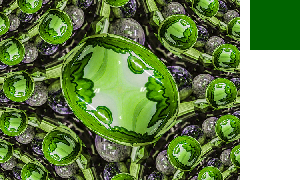

('gold', 'darkorange', 'gold', 'ok')


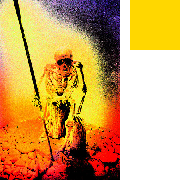

('darkslategrey', 'gainsboro', 'darkslategrey', 'ok')


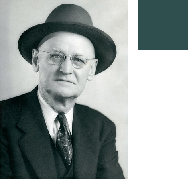

('linen', 'linen', 'linen', 'ok')


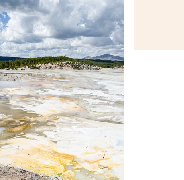

In [29]:
key1 = dominant_color_key4(image1, pixel_func=rulethirdsq)
print(key1)
show_image_name_colors(image1, [key1[0]])
key2 = dominant_color_key4(image2, pixel_func=rulethirdsq)
print(key2)
show_image_name_colors(image2, [key2[0]])    
key3 = dominant_color_key4(image3, pixel_func=rulethirdsq)
print(key3)
show_image_name_colors(image3, [key3[0]])   
key4 = dominant_color_key4(image4, portion=2, pixel_func=rulethirdsq)
print(key4)
show_image_name_colors(image4, [key4[0]])   

When `dominant_color_key4` is applied to the same collection of SmugMug images
used in prior tests we get:

        +-----+-----------------+---------+-----------+-----------+-------+
        |count|color key        |frequency|percent    |cummulative|reverse|
        +-----+-----------------+---------+-----------+-----------+-------+
        |  1  |`darkolivegreen  |225      |  5.8244887|5.8244887  |3863   |
        |  2  |`darkslategrey   |221      |  5.7209423|11.545431  |3638   |
        |  3  |`cornflowerblue  |206      |   5.332643|16.878074  |3417   |
        |  4  |`steelblue       |200      |  5.1773233|22.055397  |3211   |
        |  5  |`tan             |149      |  3.8571059|25.912503  |3011   |
        |  6  |`black           |147      |  3.8053326|29.717836  |2862   |
        |  7  |`peru            |146      |   3.779446|33.497282  |2715   |
        |  8  |`rosybrown       |138      |  3.5723531|37.069635  |2569   |
        |  9  |`sienna          |114      |  2.9510743|40.020709  |2431   |
        | 10  |`lightsteelblue  |109      |  2.8216412|42.842351  |2317   |
        | 11  |`silver          | 96      |  2.4851152|45.327466  |2208   |
        | 12  |`indianred       | 90      |  2.3297955|47.657261  |2112   |
        | 13  |`skyblue         | 86      |   2.226249| 49.88351  |2022   |
        | 14  |`saddlebrown     | 83      |  2.1485892|52.032099  |1936   |
        | 15  |`gainsboro       | 80      |  2.0709293|54.103029  |1853   |
        | 16  |`olivedrab       | 76      |  1.9673829|56.070412  |1773   |
        | 17  |`darkgrey        | 75      |  1.9414962|58.011908  |1697   |
        | 18  |`lavender        | 72      |  1.8638364|59.875744  |1622   |
        | 19  |`goldenrod       | 66      |  1.7085167|61.584261  |1550   |
        | 20  |`lightgrey       | 64      |  1.6567435|63.241004  |1484   |
        | 21  |`darkkhaki       | 58      |  1.5014238|64.742428  |1420   |
        | 22  |`lightblue       | 57      |  1.4755371|66.217965  |1362   |
        | 23  |`lightslategrey  | 54      |  1.3978773|67.615843  |1305   |
        | 24  |`crimson         | 51      |  1.3202174| 68.93606  |1251   |
        | 25  |`grey            | 47      |   1.216671|70.152731  |1200   |
        | 26  |`chocolate       | 45      |  1.1648977|71.317629  |1153   |
        | 27  |`burlywood       | 44      |  1.1390111| 72.45664  |1108   |
        | 28  |`whitesmoke      | 44      |  1.1390111|73.595651  |1064   |
        | 29  |`sandybrown      | 44      |  1.1390111|74.734662  |1020   |
        | 30  |`darkgoldenrod   | 43      |  1.1131245|75.847787  | 976   |
        | 31  |`midnightblue    | 43      |  1.1131245|76.960911  | 933   |
        | 32  |`firebrick       | 42      |  1.0872379|78.048149  | 890   |
        | 33  |`teal            | 42      |  1.0872379|79.135387  | 848   |
        | 34  |`maroon          | 41      |  1.0613513|80.196738  | 806   |
        | 35  |`darkslateblue   | 38      | 0.98369143| 81.18043  | 765   |
        | 36  |`cadetblue       | 38      | 0.98369143|82.164121  | 727   |
        | 37  |`brown           | 37      | 0.95780481|83.121926  | 689   |
        | 38  |`gold            | 29      | 0.75071188|83.872638  | 652   |
        | 39  |`powderblue      | 28      | 0.72482527|84.597463  | 623   |
        | 40  |`royalblue       | 27      | 0.69893865|85.296402  | 595   |
        | 41  |`wheat           | 26      | 0.67305203|85.969454  | 568   |
        | 42  |`linen           | 24      |  0.6212788|86.590733  | 542   |
        | 43  |`darksalmon      | 23      | 0.59539218|87.186125  | 518   |
        | 44  |`darkcyan        | 23      | 0.59539218|87.781517  | 495   |
        | 45  |`dimgrey         | 23      | 0.59539218|88.376909  | 472   |
        | 46  |`lightskyblue    | 22      | 0.56950557|88.946415  | 449   |
        | 47  |`yellowgreen     | 20      | 0.51773233|89.464147  | 427   |
        | 48  |`snow            | 19      | 0.49184572|89.955993  | 407   |
        | 49  |`dodgerblue      | 19      | 0.49184572|90.447838  | 388   |
        | 50  |`khaki           | 16      | 0.41418587|90.862024  | 369   |
        | 51  |`olive           | 16      | 0.41418587| 91.27621  | 353   |
        | 52  |`red             | 15      | 0.38829925|91.664509  | 337   |
 
             ...........................................................
             ...........................................................
             ...........................................................
      
        | 91  |`darkblue        |  3      | 0.07765985|99.042195  |  40   |
        | 92  |`darkorchid      |  3      | 0.07765985|99.119855  |  37   |
        | 93  |`blanchedalmond  |  2      |0.051773233|99.171628  |  34   |
        | 94  |`seashell        |  2      |0.051773233|99.223402  |  32   |
        | 95  |`indigo          |  2      |0.051773233|99.275175  |  30   |
        | 96  |`seagreen        |  2      |0.051773233|99.326948  |  28   |
        | 97  |`aliceblue       |  2      |0.051773233|99.378721  |  26   |
        | 98  |`magenta         |  2      |0.051773233|99.430494  |  24   |
        | 99  |`springgreen     |  2      |0.051773233|99.482268  |  22   |
        |100  |`plum            |  2      |0.051773233|99.534041  |  20   |
        |101  |`cornsilk        |  1      |0.025886617|99.559928  |  18   |
        |102  |`floralwhite     |  1      |0.025886617|99.585814  |  17   |
        |103  |`lightsalmon     |  1      |0.025886617|99.611701  |  16   |
        |104  |`darkmagenta     |  1      |0.025886617|99.637587  |  15   |
        |105  |`forestgreen     |  1      |0.025886617|99.663474  |  14   |
        |106  |`purple          |  1      |0.025886617|99.689361  |  13   |
        |107  |`blueviolet      |  1      |0.025886617|99.715247  |  12   |
        |108  |`pink            |  1      |0.025886617|99.741134  |  11   |
        |109  |`hotpink         |  1      |0.025886617| 99.76702  |  10   |
        |110  |`mintcream       |  1      |0.025886617|99.792907  |   9   |
        |111  |`mediumslateblue |  1      |0.025886617|99.818794  |   8   |
        |112  |`cyan            |  1      |0.025886617| 99.84468  |   7   |
        |113  |`chartreuse      |  1      |0.025886617|99.870567  |   6   |
        |114  |`lightcyan       |  1      |0.025886617|99.896454  |   5   |
        |115  |`lightyellow     |  1      |0.025886617| 99.92234  |   4   |
        |116  |`mediumblue      |  1      |0.025886617|99.948227  |   3   |
        |117  |`violet          |  1      |0.025886617|99.974113  |   2   |
        |118  |`turquoise       |  1      |0.025886617|      100  |   1   |
        +-----+-----------------+---------+-----------+-----------+-------+



### Collecting Large Samples of Computed Dominant Colors

The following cells apply `dominant_color_key4` to my directories of SmugMug 
sample images. There are currently around 4,000 sample images in these 
directories. My sample images are small `jpg` versions of the larger images 
on SmugMug. If you adjust this code to apply to your own directories of 
images I strongly suggest resizing images or you will be waiting. On my
current machine it still takes about two hours to process all 4,000 images.

In [30]:
# gather unique list of sample image files 

# the same image may occur in many gallery directories
unique_files = set()
unique_full_paths = []
for i, full_path in enumerate(glob.iglob('c:\SmugMirror\Mirror\**\*.jpg', recursive=True)):
    file_name = os.path.basename(full_path)
    if file_name in unique_files:
        #print("duplicate -> %s, %s" % (i,file_name))
        continue
    unique_files.add(file_name)
    unique_full_paths.append(full_path)
    
print(len(unique_full_paths))

3863


In [31]:
# collect sample of dominant colors
rows = []
file_count = len(unique_full_paths)
for i, file_name in enumerate(unique_full_paths):
    #image = Image.open(file_name)
    image = Image.open(random.choice(unique_full_paths))
    dominant_color, overall_color, rule3_color, flag = dominant_color_key4(image, portion=5, pixel_func=rulethirdsq)
    color_info = {'Color': dominant_color, 
                  'Overall': overall_color,
                  'Rule3': rule3_color,
                  'Flag': flag,
                  'SampleFile': file_name}
    rows.append(color_info)
    # every n rows print message
    if 0 == (i % 20):
        print("%s/%s %s - %s" % (i + 1, file_count, dominant_color, os.path.basename(file_name)))
    if i > 100:
        break

# write TAB delimited file    
sample_file = "c:/temp/dominant_color.txt"
keys = rows[0].keys()
with open(sample_file, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys, dialect='excel-tab')
    dict_writer.writeheader()
    dict_writer.writerows(rows)
print("file written -> " + sample_file)

1/3863 darkgoldenrod - 2BCNG5j-1o-IMG_0029.JPG
21/3863 yellowgreen - 2FVN936-1k-anathem.jpg
41/3863 powderblue - FBkwG7D-2t-isabelle_intro.jpg
61/3863 midnightblue - PnM2XvX-2d-prometheus_movie.jpg
81/3863 lightslategrey - VTHCgxD-3d-HeadUpAssLogo.jpg
101/3863 darkgrey - 5ZJ6wn3-1c-hazel-august-1944-[350452336].jpg
file written -> c:/temp/dominant_color.txt


### Final Remarks

Of the four dominant color methods the last `dominant_color_key4` produces the most
evenly distributed results. It uses more colors and spreads the first two quartiles
over a larger set of colors. These improvments do not change the fact that
colors selected by *kmeans* based algorithms do not always align with photographer 
expectations. To get better colors more sophisticated methods must be used.

**Regardless of the sophistication of the selection algorithm any method that 
reduces over sixteen million choices to one is going to produce results that
not everyone will agree with.**

Still, the color keys computed here do provide another useful way of browsing 
large collections of images by similar colors.